# QNN_qiskit.ipynb
This Jupyter Notebook demonstrates the implementation of a Quantum Neural Network (QNN) using Qiskit and various machine learning libraries. The notebook includes the following key components:

## Imports
The following libraries and modules are imported at the beginning of the notebook:

In [1]:
from qiskit.circuit import parameter
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
from sklearn.datasets import load_iris, fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Data Preparation
In this section, we will load the MNIST dataset, filter it to include only the digits '1' and '3', and preprocess the data using PCA and scaling techniques.

In [2]:
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target

X_filtered = X[(y == '1') | (y == '3')]
y_filtered = y[(y == '1') | (y == '3')]

y_filtered = np.where((y_filtered == '1'), 0, 1)

## PCA Analysis
In this section, we will perform PCA on the filtered MNIST dataset to determine the number of components required to retain 50% of the variance. This will help in reducing the dimensionality of the dataset while preserving important information.

In [ ]:
pca = PCA()
pca.fit(X_filtered)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
n_components = np.argmax(cumulative_variance >= 0.50) + 1

print(f"Number of components to retain 50% variance: {n_components}")

Number of components to retain 50% variance: 6


## Data Preprocessing
In this section, we will reduce the dimensionality of the filtered MNIST dataset using PCA and scale the data using StandardScaler and MinMaxScaler. This will prepare the data for training the Quantum Neural Network (QNN) and classical machine learning models.

In [6]:
n_components = 6

pca_reduced = PCA(n_components=n_components)
X_reduced = pca_reduced.fit_transform(X_filtered)

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_filtered, test_size=0.33, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

X = np.append(X_train, X_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(X)
X_train = minmax_scale.transform(X_train)
X_test = minmax_scale.transform(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

## Quantum Neural Network (QNN) Implementation
In this section, we will define the Quantum Neural Network (QNN) using Qiskit's Variational Quantum Classifier (VQC). We will create the feature map and ansatz circuits, and then initialize the VQC with these circuits and the COBYLA optimizer.

In [43]:
inputs = ParameterVector("input", n_components)
weights = ParameterVector("weight", n_components*2)

feature_map = QuantumCircuit(n_components)
for i in range(n_components):
    feature_map.ry(inputs[i], i)

ansatz = QuantumCircuit(n_components)

for i in range(n_components):
    ansatz.ry(weights[i], i)
    ansatz.cx(i, (i + 1) % n_components)
    ansatz.ry(weights[i + n_components], i)

vqc = VQC(feature_map=feature_map,
          ansatz=ansatz,
          optimizer=COBYLA(maxiter=100),
)

In [44]:
accuracy_list = {}

for size_QML in range(10, 101, 10):
  idx_0 = np.where(y_train == 0)[0]
  idx_1 = np.where(y_train == 1)[0]

  idx_0_sampled = np.random.choice(idx_0, size=size_QML, replace=False)
  idx_1_sampled = np.random.choice(idx_1, size=size_QML, replace=False)

  sampled_indices = np.concatenate([idx_0_sampled, idx_1_sampled])

  X_train_sampled = X_train[sampled_indices]
  y_train_sampled = y_train[sampled_indices]

  vqc.fit(X_train_sampled, y_train_sampled)
  y_pred = vqc.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  accuracy_list[size_QML] = accuracy
  print(f"Size of QML: {size_QML}, Accuracy: {accuracy}")

Size of QML: 10, Accuracy: 0.9299838579499596
Size of QML: 20, Accuracy: 0.7990314769975787
Size of QML: 30, Accuracy: 0.8196125907990315
Size of QML: 40, Accuracy: 0.7863196125907991
Size of QML: 50, Accuracy: 0.947134786117837
Size of QML: 60, Accuracy: 0.8617836965294592
Size of QML: 70, Accuracy: 0.8436238902340597
Size of QML: 80, Accuracy: 0.9531880548829701
Size of QML: 90, Accuracy: 0.8539144471347861
Size of QML: 100, Accuracy: 0.774818401937046


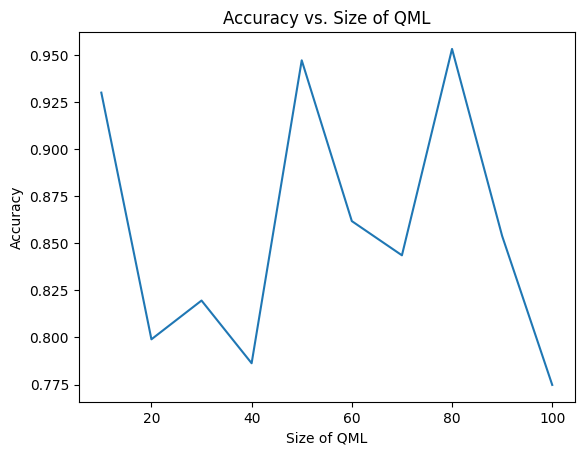

In [45]:
sns.lineplot(x=list(accuracy_list.keys()), y=list(accuracy_list.values()))
plt.xlabel('Size of QML')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Size of QML')
plt.show()

Accuracy: 0.9921307506053268


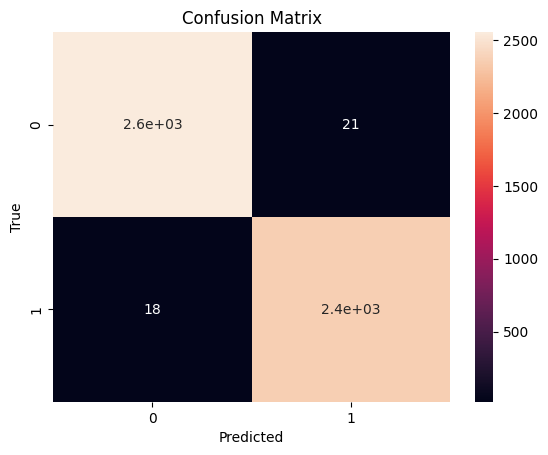

In [8]:
mlp = MLPClassifier(
    hidden_layer_sizes=(10, 10),
    max_iter=1000,
    random_state=42
)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()